In [80]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
sns.set()

import matplotlib as mpl
mpl.rcParams['figure.figsize'] = (18,12)
mpl.rcParams['axes.grid'] = False
sns.set_style('whitegrid')

import torch
import torch.nn as nn

In [15]:
# Upload the data frame into the notebook
data_frame = pd.read_csv('Data/generated_data.csv')

In [16]:
display(data_frame.head(5))

,x1,u1
0,0.000000,-0.450823
1,0.000000,0.397961
2,-0.334935,1.500000
3,-0.528112,2.455209
4,0.827129,2.877874


In [17]:
# Defining a batch size based on the data
batch_size = 101

# Split the dataset into different batches
batch_data = np.array_split(data_frame, int(data_frame.shape[0]/batch_size))

# Shifting batch number 5 to the end to be used as a test data
batch_data.append(batch_data.pop(5))

# Combining all the batches to form a single dataset
df = pd.DataFrame(np.concatenate(batch_data),columns=list(data_frame.columns))

/home/sebu/miniconda3/envs/rnn4nds/lib/python3.12/site-packages/numpy/core/fromnumeric.py:59: FutureWarning: 'DataFrame.swapaxes' is deprecated and will be removed in a future version. Please use 'DataFrame.transpose' instead.
  return bound(*args, **kwds)


In [22]:
batch_data

[           x1            u1
 0    0.000000 -4.508234e-01
 1    0.000000  3.979606e-01
 2   -0.334935  1.500000e+00
 3   -0.528112  2.455209e+00
 4    0.827129  2.877874e+00
 ..        ...           ...
 107 -1.469914 -2.452389e-15
 108 -1.521030 -1.492150e+00
 109 -1.127995 -2.546027e+00
 110 -0.743782 -2.877874e+00
 111 -8.545374 -2.455209e+00
 
 [112 rows x 2 columns],
            x1        u1
 112 -5.966681 -1.500000
 113 -3.821926 -0.397961
 114 -2.285770  0.450823
 115 -1.508950  0.782671
 116 -1.539472  0.565099
 ..        ...       ...
 218 -0.801770 -0.565099
 219 -0.509499 -0.782671
 220  0.122561 -0.450823
 221  0.369002  0.397961
 222  0.531212  1.500000
 
 [111 rows x 2 columns],
            x1            u1
 223 -0.131554  2.455209e+00
 224  1.748811  2.877874e+00
 225  1.592661  2.546027e+00
 226  4.258285  1.492150e+00
 227 -1.471967  4.895492e-15
 ..        ...           ...
 329  0.162610 -2.546027e+00
 330 -1.667825 -2.877874e+00
 331 -3.086786 -2.455209e+00
 332 -2.

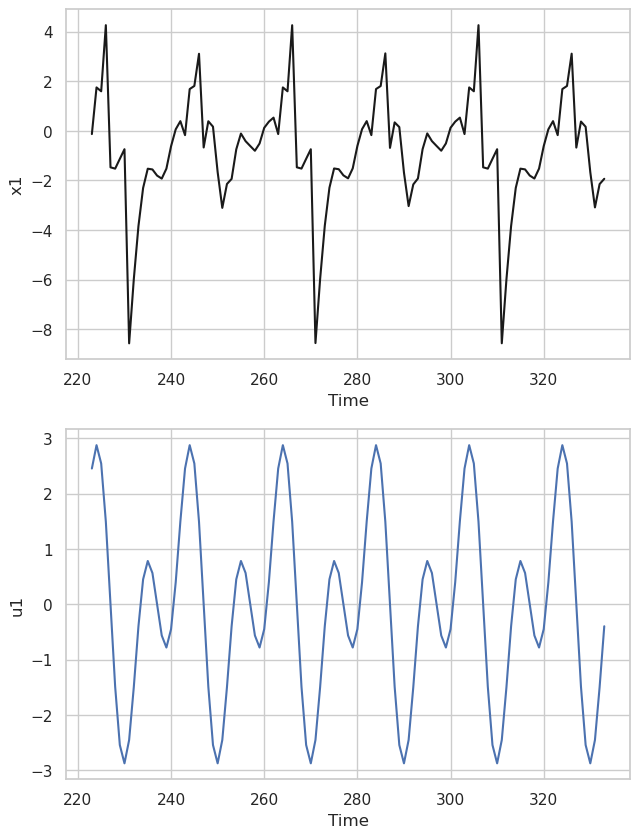

In [79]:
# Plotting the test data batch
fig = plt.figure(figsize=(16,10))

batch_no = 3

plt.subplot(2, 2, 1)
plt.plot(batch_data[batch_no-1]['x1'],'k')
plt.xlabel('Time')
plt.ylabel('x1')


plt.subplot(2, 2, 3)
plt.plot(batch_data[batch_no-1]['u1'],'b')
plt.xlabel('Time')
plt.ylabel('u1')


plt.show()

In [26]:
# Define a test size
test_size = batch_size

y = df.values.astype(float)

# Create train and test sets
train_set = y[:-test_size]
test_set = y[-test_size:]

# Convert train set into a torch tensor
train_set = torch.FloatTensor(train_set).view(-1,df.shape[1])
test_set = torch.FloatTensor(test_set).view(-1,df.shape[1])

In [27]:
# Creating a function to generate the input data for the lstm 
def input_data(seq,ws):
    
    inp_data = []
    
    for bat in range(0,train_set.shape[0],batch_size):
        
        bat_seq = seq[bat:bat+101]
        l = len(bat_seq)
        
        window = []
        label = []
        
        for i in range(l-ws):
        
            window = bat_seq[i:i+ws]
            label = bat_seq[i+ws:i+ws+1,:2]

            inp_data.append((window,label))
        
    return inp_data

In [28]:
# Defining a window size for prediction
window_size = 1
train_data = input_data(train_set,window_size)

In [32]:
from classy import LSTMModel

# Creating a model instance, loss function and the optimizer
model = LSTMModel(input_size=2,hidden_size_1=50,hidden_size_2=50,out_size=1)

criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(),lr=0.001)

In [33]:
display(model)

LSTMModel(
  (lstm_1): LSTM(2, 50)
  (lstm_2): LSTM(50, 50)
  (linear): Linear(in_features=50, out_features=1, bias=True)
)

In [34]:
display(optimizer)

Adam (
Parameter Group 0
    amsgrad: False
    betas: (0.9, 0.999)
    capturable: False
    differentiable: False
    eps: 1e-08
    foreach: None
    fused: None
    lr: 0.001
    maximize: False
    weight_decay: 0
)

In [35]:
def count_parameters(model):
    params = [p.numel() for p in model.parameters() if p.requires_grad]
    for item in params:
        print(f'{item:>6}')
    print(f'______\n{sum(params):>6}')
    
count_parameters(model)

   400
 10000
   200
   200
 10000
 10000
   200
   200
    50
     1
______
 31251


In [36]:
# Set the number of epochs

epochs = 100

for epoch in range(epochs):
    
    # Running each batch separately 
    
    for bat in range(0,1400,100):
    
        for seq,label in train_data[bat:bat+100]:
            
            # set the optimization gradient to zero

            optimizer.zero_grad()
            
            # initialize the hidden states

            model.hidden_1 = (torch.zeros(1,1,model.hidden_size_1),
                            torch.zeros(1,1,model.hidden_size_1))

            model.hidden_2 = (torch.zeros(1,1,model.hidden_size_2),
                            torch.zeros(1,1,model.hidden_size_2))
            
            # Make predictions on the current sequence

            y_pred = model(seq)
            
            # Compute the loss

            loss = criterion(y_pred, label)
            
            # Perform back propogation and gradient descent

            loss.backward()

            optimizer.step()

    if epoch%10 == 0:

        print(f'Epoch: {epoch} Loss: {loss.item():10.8f}')

/home/sebu/miniconda3/envs/rnn4nds/lib/python3.12/site-packages/torch/nn/modules/loss.py:535: UserWarning: Using a target size (torch.Size([1, 2])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Epoch: 0 Loss: 0.14985164
Epoch: 10 Loss: 0.30935973
Epoch: 20 Loss: 0.27543983
Epoch: 30 Loss: 0.23447098
Epoch: 40 Loss: 0.20372641
Epoch: 50 Loss: 0.18026946
Epoch: 60 Loss: 0.16564412
Epoch: 70 Loss: 0.15343033
Epoch: 80 Loss: 0.15871187
Epoch: 90 Loss: 0.16328932


In [71]:
future = 100

# Set the model to evaluation mode

model.eval()

preds = [test_set[0,:1].reshape(-1,1)]
print(test_set[0,:2])
print(preds)
for i in range(future):
    
    seq = test_set[i].reshape(-1,2)
    
    # Informing PyTorch that I am no longer interested in the gradients
    
    with torch.no_grad():
        
        # Initialize the hidden states
        
        model.hidden_1 = (torch.zeros(1,1,model.hidden_size_1),
                        torch.zeros(1,1,model.hidden_size_1))
        model.hidden_2 = (torch.zeros(1,1,model.hidden_size_2),
                        torch.zeros(1,1,model.hidden_size_2))
        
        preds.append(model(seq))
print(preds)       

tensor([3.1132, 1.4921])
[tensor([[3.1132]])]
[tensor([[3.1132]]), tensor([[-0.3077]]), tensor([[-0.5962]]), tensor([[-1.1933]]), tensor([[-2.2693]]), tensor([[-2.7508]]), tensor([[-1.8143]]), tensor([[-1.1680]]), tensor([[-0.1557]]), tensor([[0.3314]]), tensor([[0.0982]]), tensor([[-0.3029]]), tensor([[-0.6714]]), tensor([[-0.6216]]), tensor([[-0.2089]]), tensor([[0.3866]]), tensor([[1.0149]]), tensor([[1.1309]]), tensor([[2.3531]]), tensor([[2.2100]]), tensor([[3.0314]]), tensor([[-0.6488]]), tensor([[-1.5024]]), tensor([[-1.8372]]), tensor([[-1.8130]]), tensor([[-5.5220]]), tensor([[-3.7443]]), tensor([[-2.1144]]), tensor([[-0.9187]]), tensor([[-0.3846]]), tensor([[-0.5212]]), tensor([[-0.8747]]), tensor([[-1.2478]]), tensor([[-1.1203]]), tensor([[-0.5011]]), tensor([[0.2267]]), tensor([[0.9466]]), tensor([[1.2287]]), tensor([[2.2519]]), tensor([[2.3590]]), tensor([[2.3782]]), tensor([[-0.3085]]), tensor([[-0.5948]]), tensor([[-1.1926]]), tensor([[-2.2696]]), tensor([[-2.7495]]), te

In [73]:
predictions = np.array([pred.numpy() for pred in preds]).reshape(-1,1)
true_values = np.array(test_set[:,:2])

Text(0, 0.5, 'x1')

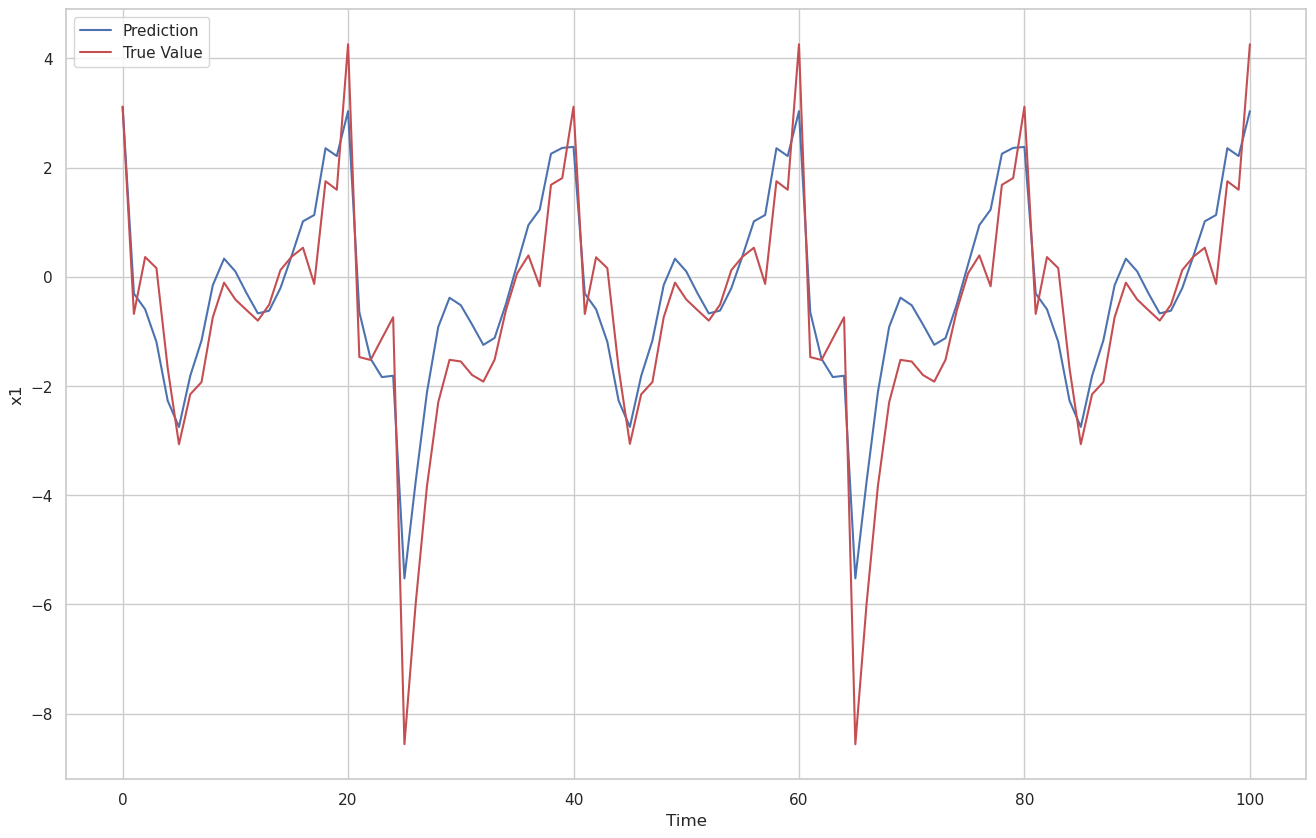

In [77]:
fig = plt.figure(figsize=(16,10))

plt.plot(predictions[:,0],'b',label='Prediction')
plt.plot(true_values[:,0],'r',label='True Value')
plt.legend()
plt.xlabel('Time')
plt.ylabel('x1')

In [78]:
RMSE = np.sqrt(np.sum(np.square((predictions - true_values)))/202)
display(RMSE)

0.9249003457972031